## The Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# Imports

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from scipy.misc import imresize

from moviepy.editor import VideoFileClip
from IPython.display import HTML

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


%matplotlib inline
plt.rcParams['figure.figsize'] = 16, 10


In [2]:
from IPython.core.debugger import set_trace


# Camera Calibration

For the camera calibration code from the [opencv camera calibration example](https://docs.opencv.org/3.3.0/dc/dbb/tutorial_py_calibration.html) was adapted.

## Calibration Functions

In [3]:
def get_camera_calibration(image_paths, columns, rows, verbose = False):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((columns * rows,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list of calibration images and search for chessboard corners
    file_counter = 0
    chessboard_counter = 0

    for fname in image_paths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        file_counter += 1
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (columns, rows),None)

        # If found, add object points, image points
        if ret:
            objpoints.append(objp)
            imgpoints.append(corners)
            chessboard_counter += 1
            
    if verbose:
        print("found {} chessboards in {} images.".format(chessboard_counter, file_counter))

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist


In [4]:
def undistort(img, calibration_values):
    mtx = calibration_values[0]
    dist = calibration_values[1]
    return cv2.undistort(img, mtx, dist, None, mtx)


## Project Camera Calibration

In [5]:
chessboard_images = glob.glob('./camera_cal/calibration*.jpg')

calibration_values = get_camera_calibration(chessboard_images, 9, 6, True)

found 17 chessboards in 20 images.


## Project Camera Undistort Examples

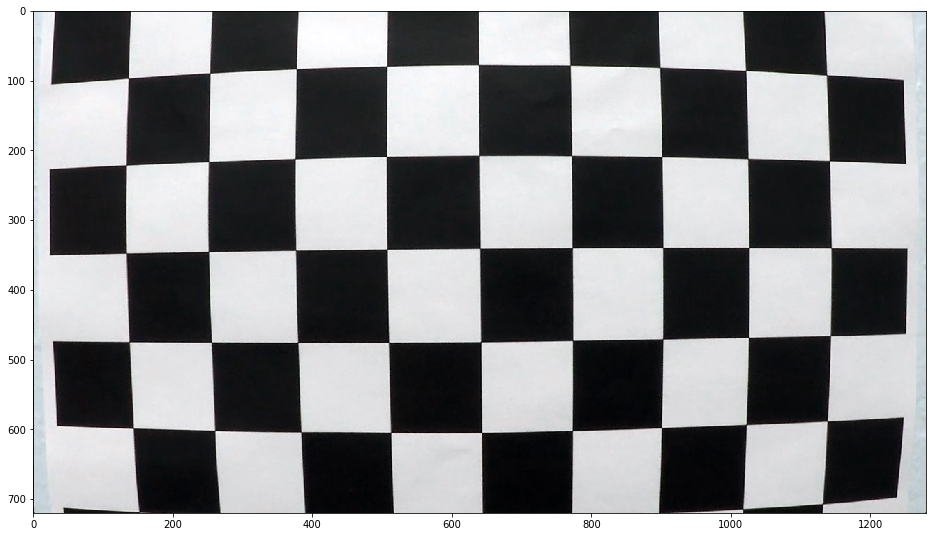

In [6]:
image = cv2.imread(chessboard_images[0])
plt.imshow(image)

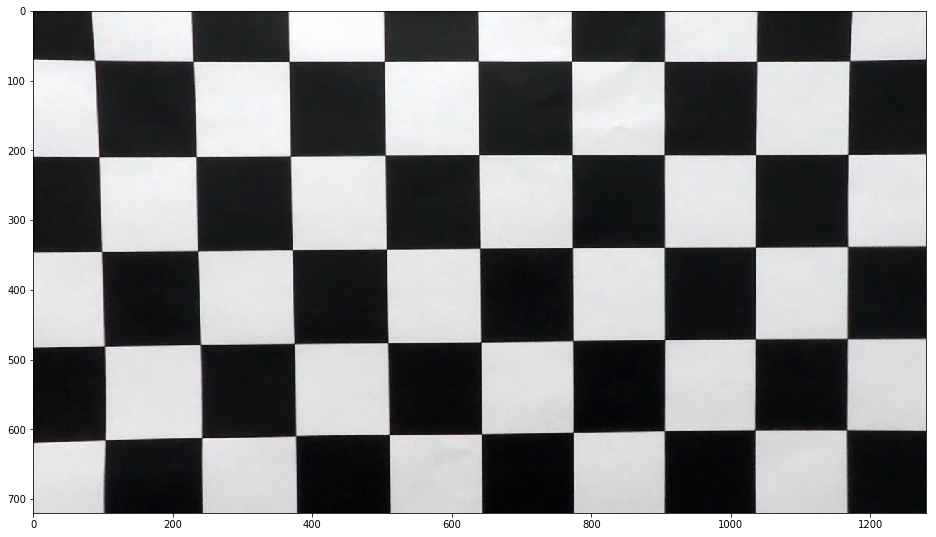

In [7]:
undistorted_image = undistort(image, calibration_values)
plt.imshow(undistorted_image)

## Gopro Calibration

I made my own videos and calibrations images with a gapro session hero 4.

In [8]:
gopro_images = glob.glob('./gopro_cal/*.png')

gopro_calibration_values = get_camera_calibration(gopro_images, 9, 6, True)

found 20 chessboards in 20 images.


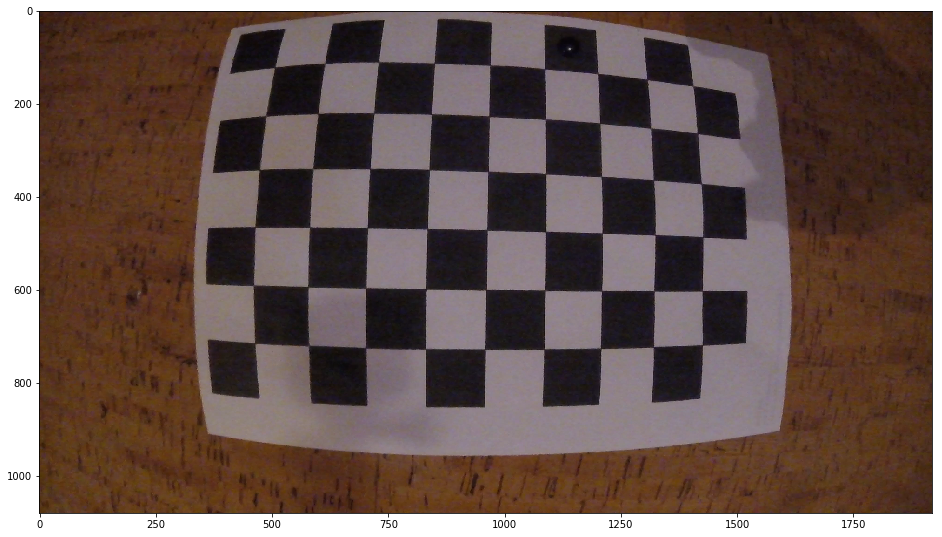

In [9]:
image = cv2.cvtColor(cv2.imread(gopro_images[18]), cv2.COLOR_BGR2RGB)
plt.imshow(image)

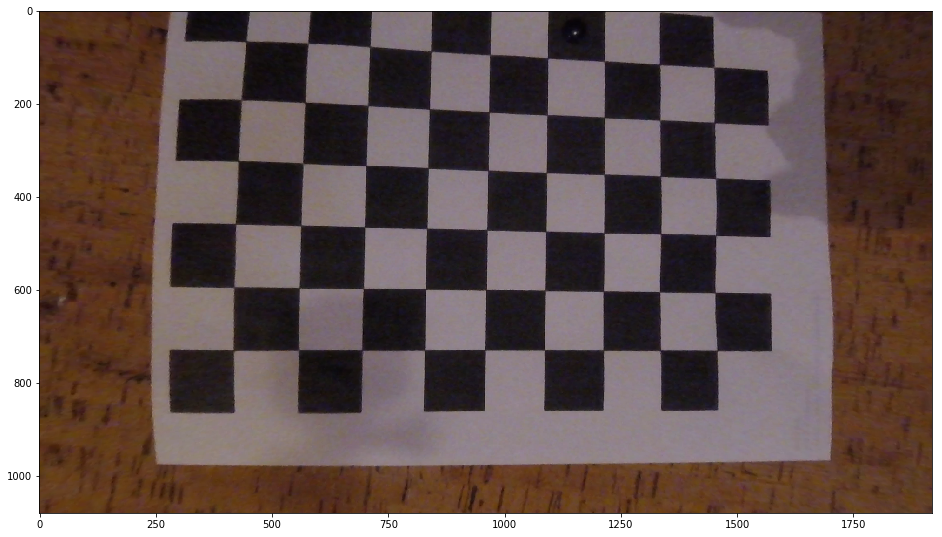

In [10]:
undistorted_image = undistort(image, gopro_calibration_values)
plt.imshow(undistorted_image)

## Undistort Test Images

Load and undistort images.

In [11]:
test_image_paths = glob.glob('./test_images/*.jpg')

test_images = []
undistorted_test_images = []

for image_path in test_image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    test_images.append(image)
    undistorted_test_images.append(undistort(image, calibration_values))

### Original Image Example

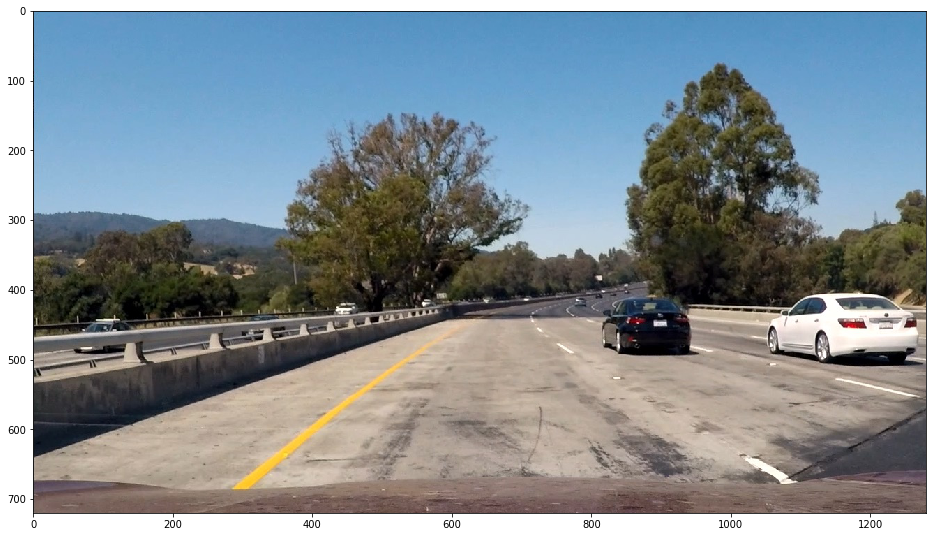

In [12]:
plt.imshow(test_images[2])

### Undistorted Image Example

The difference is hard to see. Most notetable is the car on the right which appears to be nearer to the edge due to the undistortion.

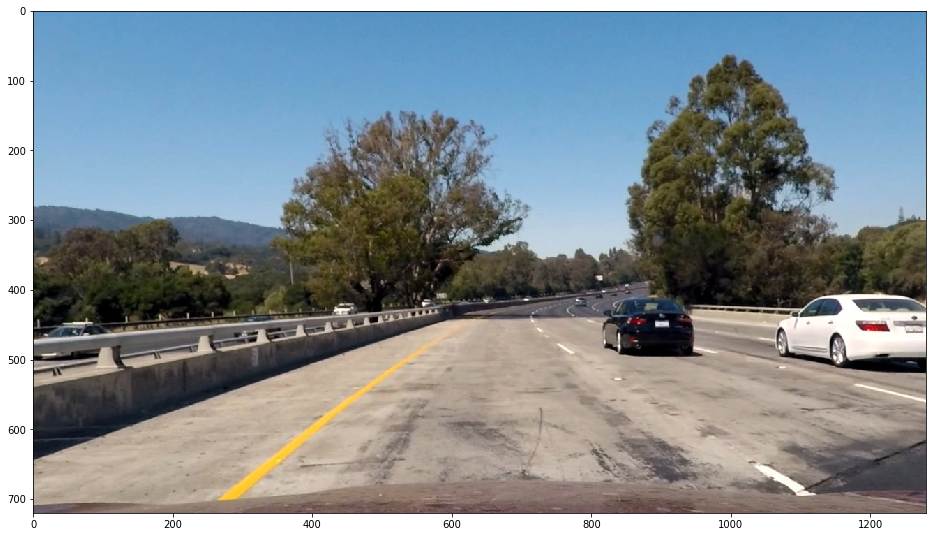

In [13]:
plt.imshow(undistorted_test_images[2])

## Gopro Image Example

In [14]:
gopro_test_image_paths = glob.glob('./gopro_test_images/*.png')

gopro_test_images = []
gopro_undistorted_test_images = []

for image_path in gopro_test_image_paths:
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    undistorted_image = undistort(image, gopro_calibration_values)
    image = imresize(image, (720, 1280))
    undistorted_image = imresize(undistorted_image, (720, 1280))
    gopro_test_images.append(image)
    gopro_undistorted_test_images.append(undistorted_image)

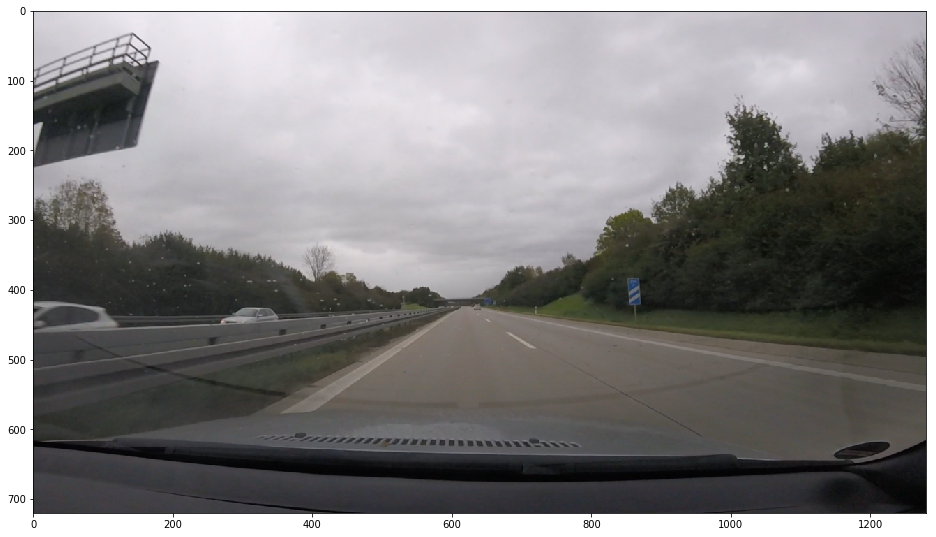

In [15]:
plt.imshow(gopro_test_images[0]);

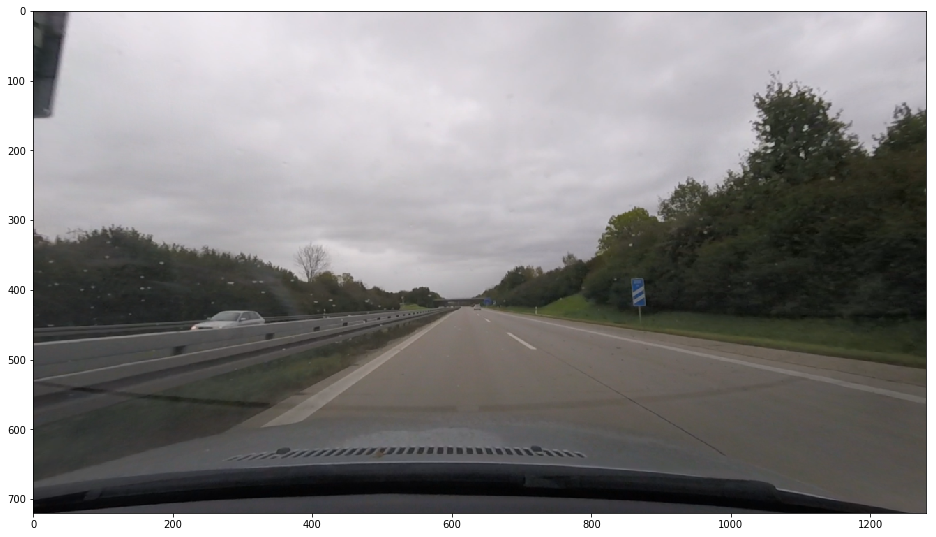

In [16]:
plt.imshow(gopro_undistorted_test_images[0]);

In [17]:
#for image in gopro_undistorted_test_images:
#    undistorted_test_images.append(image)

In [18]:
len(undistorted_test_images)

8

# Image Filters

Here are the functions developed in the course to create a binary output of an image from which you could detect lane lines.

In [19]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == "x":
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else: 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    return binary_output

In [20]:
def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # Rescale to 8 bit
    scale_factor = np.max(magnitude)/255 
    magnitude = (magnitude/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(magnitude)
    binary_output[(magnitude >= mag_thresh[0]) & (magnitude <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

In [21]:
def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [22]:
def hls_select(image, channel = 0, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,channel]
    # 2) Apply a threshold to the S channel
    binary_output =  np.zeros_like(s_channel)
    # 3) Return a binary image of threshold result
    binary_output[(s_channel > thresh[0]) & (s_channel < thresh[1])] = 1
    return binary_output

In [120]:
def hls_multi_select(image, thresh=(20, 100, 100, 100)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output =  np.zeros_like(s_channel)
    # 3) Return a binary image of threshold result
    binary_output[(h_channel > thresh[0]) & (h_channel < thresh[1]) & (s_channel > thresh[2]) & (l_channel > thresh[3])] = 1
    return binary_output

## Visualization

Here you can use interactive sliders to find good thresholds to detect lane lines.

In [121]:
def show_abs_sobel(image_nr, orient, sobel_kernel, minthresh, maxthresh):
    plt.imshow(abs_sobel_thresh(undistorted_test_images[image_nr], orient = orient, sobel_kernel=sobel_kernel,
                                thresh= (minthresh, maxthresh)), cmap="gray")
def show_dir_sobel(image_nr, sobel_kernel, minthresh, maxthresh):
    plt.imshow(dir_threshold(undistorted_test_images[image_nr], sobel_kernel=sobel_kernel, thresh=(minthresh, maxthresh)), cmap="gray")
    
def show_mag_sobel(image_nr, sobel_kernel, minthresh, maxthresh):
    plt.imshow(mag_thresh(undistorted_test_images[image_nr], sobel_kernel=sobel_kernel, mag_thresh=(minthresh, maxthresh)), cmap="gray")
    
def show_hls_select(image_nr, channel, minthresh, maxthresh):
    plt.imshow(hls_select(undistorted_test_images[image_nr], channel=channel, thresh=(minthresh, maxthresh)), cmap="gray")
    
def show_hls_multi_select(image_nr, h_thresh_min, h_thresh_max, s_thresh, l_thresh):
    plt.imshow(hls_multi_select(undistorted_test_images[image_nr], thresh=(h_thresh_min, h_thresh_max, s_thresh, l_thresh)), cmap="gray")

<function __main__.show_abs_sobel>

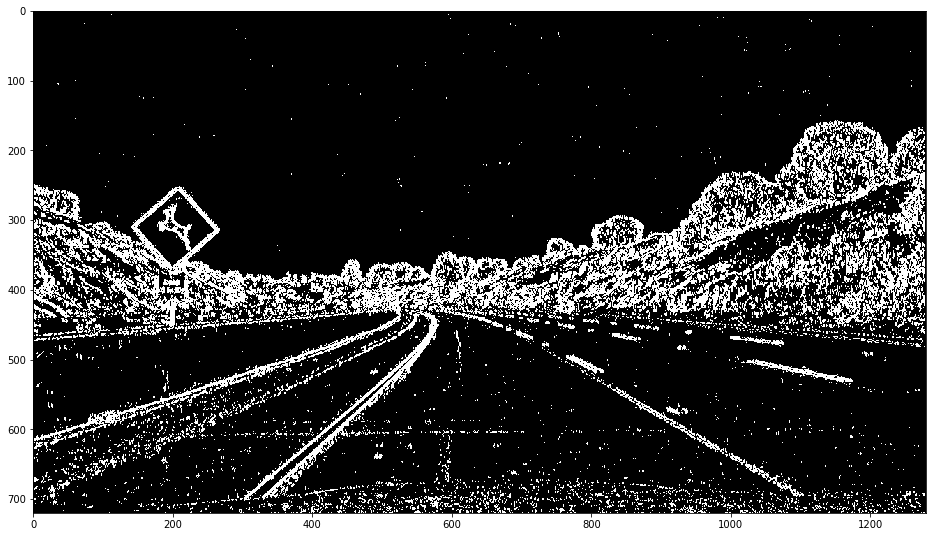

In [25]:
interact(show_abs_sobel, 
         image_nr = [0, len(undistorted_test_images) - 1],
         orient = ["x", "y"],
         sobel_kernel=widgets.IntSlider(min=1,max=31,step=2,value=3),
         minthresh=widgets.IntSlider(min=0,max=255,step=1,value=8),
         maxthresh=widgets.IntSlider(min=0,max=255,step=1,value=255))


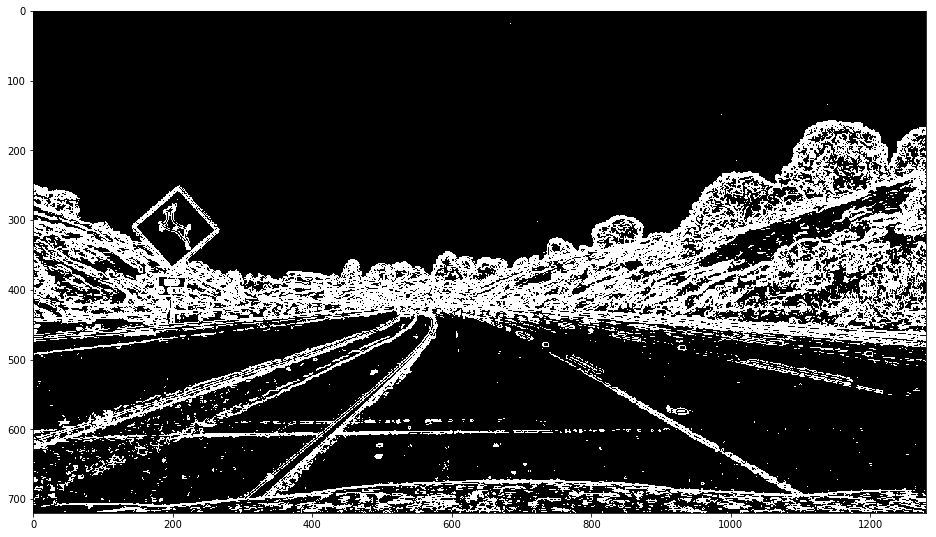

In [26]:
interact(show_mag_sobel, 
         image_nr = [0, len(undistorted_test_images) - 1],
         sobel_kernel=widgets.IntSlider(min=0,max=20,step=1,value=3),
         minthresh=widgets.IntSlider(min=0,max=255,step=1,value=10),
         maxthresh=widgets.IntSlider(min=0,max=255,step=1,value=100));


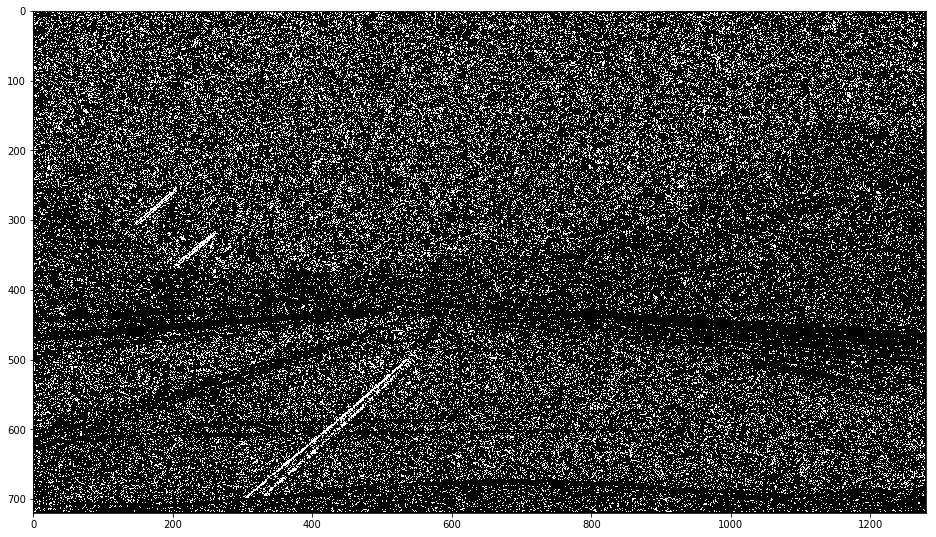

In [27]:
interact(show_dir_sobel, 
         image_nr = [0, len(undistorted_test_images) - 1],
         sobel_kernel=widgets.IntSlider(min=1,max=31,step=2,value=3),
         minthresh=widgets.FloatSlider(min=0.0,max=np.pi/2,step=0.01,value=0.78),
         maxthresh=widgets.FloatSlider(min=0.0,max=np.pi/2,step=0.01,value=0.97));


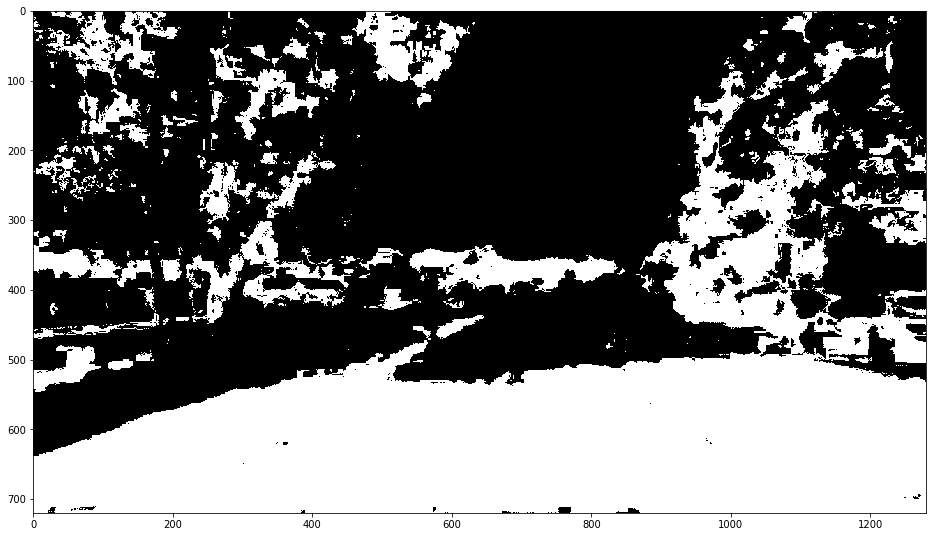

In [28]:
interact(show_hls_select, 
         image_nr = [0, len(undistorted_test_images) - 1],
         channel = {"h": 0, "l": 1, "s": 2},
         minthresh=widgets.IntSlider(min=0,max=359,step=1,value=77),
         maxthresh=widgets.IntSlider(min=0,max=359,step=1,value=359));


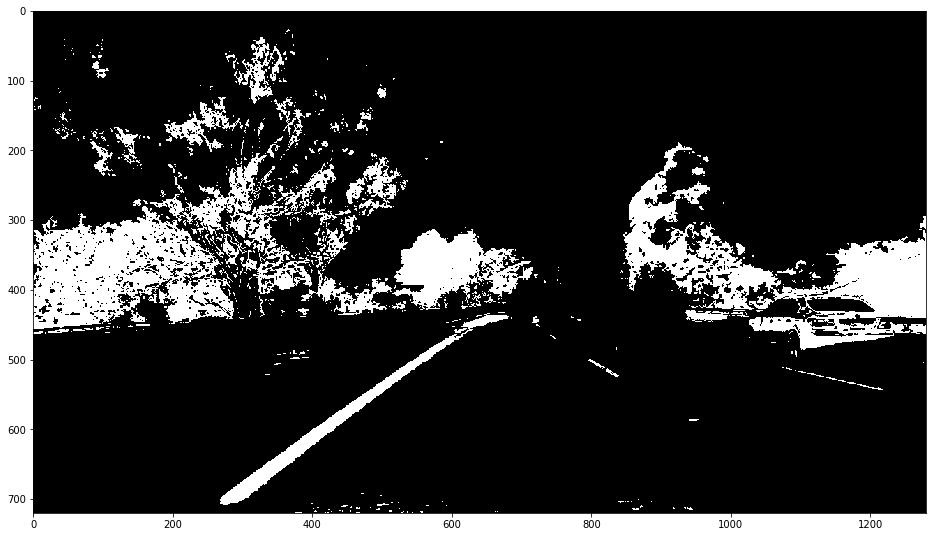

In [123]:
interact(show_hls_multi_select, 
         image_nr = [0, len(undistorted_test_images) - 1],
         h_thresh_min=widgets.IntSlider(min=0,max=359,step=1,value=195),
         h_thresh_max=widgets.IntSlider(min=0,max=359,step=1,value=195),
         l_thresh=widgets.IntSlider(min=0,max=359,step=1,value=115),
         s_thresh=widgets.IntSlider(min=0,max=359,step=1,value=100))


## Filter Combinations

It seems like the absolute sobel filter in x direction and the saturation of the hls colorspace are very promising.

In [30]:
def absolute_x_and_s(image, abs_min_tresh = 15, s_min_thresh = 110):
    abs_img = abs_sobel_thresh(image, orient="x", thresh = (abs_min_tresh, 255))
    s_img = hls_select(image, channel=2, thresh=(s_min_thresh, 360))
    combined_binary =  np.zeros_like(abs_img)
    # 3) Return a binary image of threshold result
    combined_binary[(abs_img == 1) | (s_img == 1)] = 1
    return combined_binary

In [31]:
def show_absolute_x_and_s(image_nr, abs_min_tresh, s_min_thresh):
    plt.imshow(absolute_x_and_s(undistorted_test_images[image_nr], abs_min_tresh, s_min_thresh), cmap="gray")

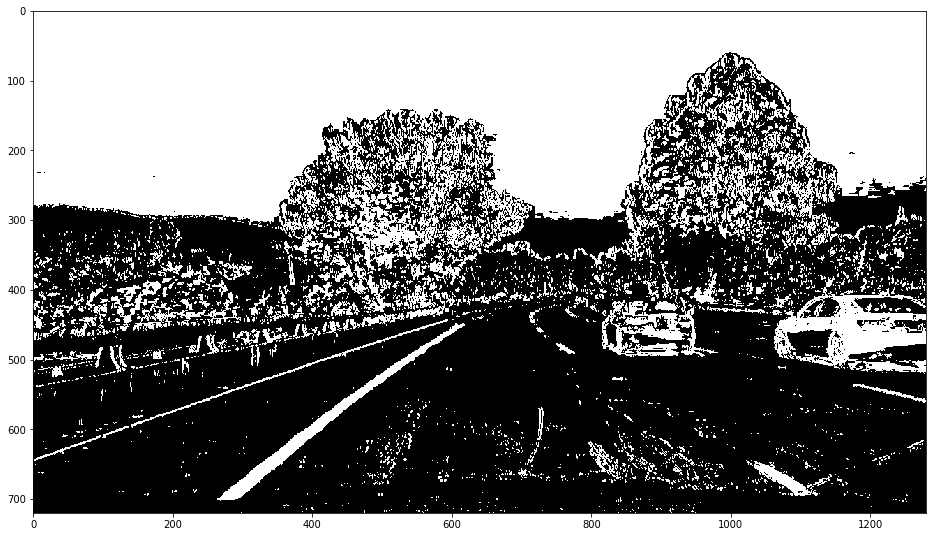

In [32]:
interact(show_absolute_x_and_s, 
         image_nr = [0, len(undistorted_test_images) - 1],
         abs_min_tresh=widgets.IntSlider(min=0,max=255,step=1,value=15),
         s_min_thresh=widgets.IntSlider(min=0,max=359,step=1,value=110))


# Perspective Transform

## Region to transform

In [33]:
def get_region_of_interest_vertices(img, x_shift_from_middle_percent = 4.4, y_shift_from_middle_percent = 12.0):
    img_width = img.shape[1]
    img_height = img.shape[0]
    
    bottom_left = (0, img_height)
    bottom_right = (img_width, img_height)
    
    x_shift_from_middle = img_width * (x_shift_from_middle_percent / 100)
    y_shift_from_middle = img_height * (y_shift_from_middle_percent / 100)

    
    middle_left = (round((img_width / 2) - x_shift_from_middle), round((img_height / 2) + y_shift_from_middle))
    middle_right = (round((img_width / 2) + x_shift_from_middle), round((img_height / 2) + y_shift_from_middle))
        
    return np.array([[bottom_left, middle_left, middle_right, bottom_right]], dtype=np.int32)


def draw_region_of_interest(img, vertices):
    work_on_img = np.copy(img)
    result = cv2.polylines(work_on_img, vertices, isClosed = True, thickness = 3, color = (255,0,0))
    return result

## Intuitively picked region

I picked the region on intuition. As you can see, it is not a good choice.

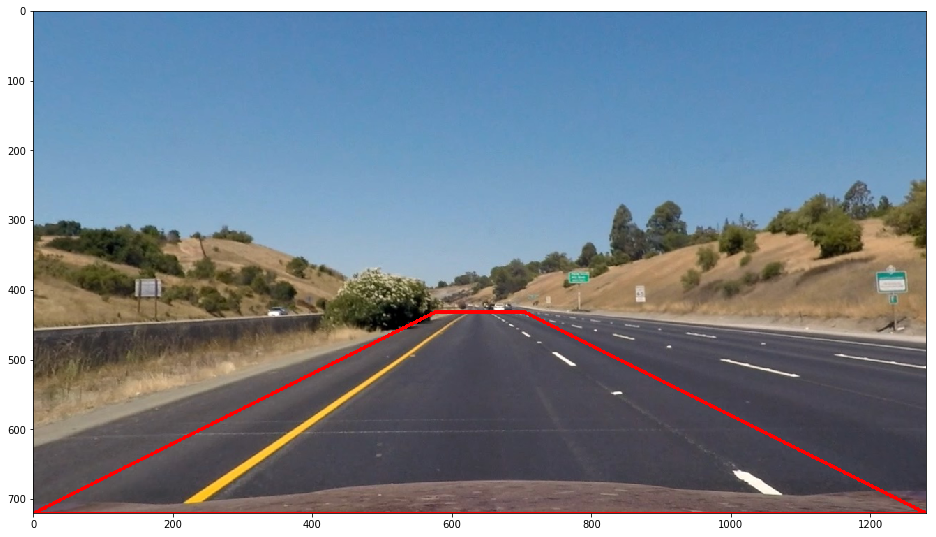

In [34]:
verts = get_region_of_interest_vertices(undistorted_test_images[0], 5, 10)
plt.imshow(draw_region_of_interest(undistorted_test_images[0], verts))

In [35]:
verts

array([[[   0,  720],
        [ 576,  432],
        [ 704,  432],
        [1280,  720]]], dtype=int32)

In [36]:
def get_image_corner_vertices(image):
    width = image.shape[1]
    height = image.shape[0]
    return [[0, height], [0, 0], [width, 0], [width, height]]


In [37]:
def perspective_transform(image, vertices):

    width = image.shape[1]
    height = image.shape[0]
    
    selected_points = np.float32(vertices)
    target_points = np.float32(get_image_corner_vertices(image))

    transform = cv2.getPerspectiveTransform(selected_points, target_points)
    warped = cv2.warpPerspective(image, transform, (width, height), flags=cv2.INTER_LINEAR)
    return warped

In [38]:
warped = perspective_transform(undistorted_test_images[0], verts)

In the following image, i would expect straight lines. But the transformation vertices are not picked very well.

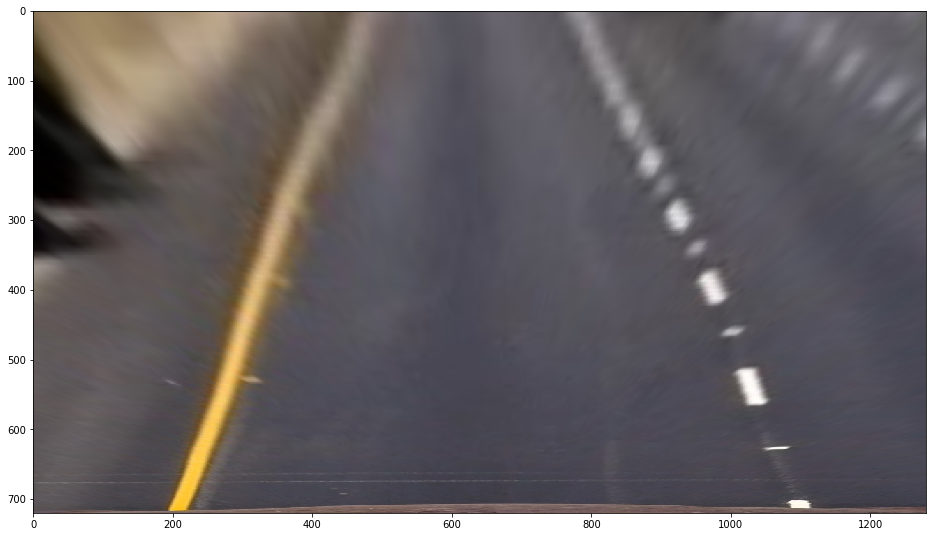

In [39]:
plt.imshow(warped)

## Visually picking transform values.

Therfore I will use interactive sliders to visually pick good values. If you run the notebook you can see sliders to select the the placement of the transform vertices. You wont see these in the html version. When these sliders are moved, the images are updated to show the new rectangle and warped image.

In [40]:
def show_warp(image_nr, x_deviation, y_deviation):
    verts = get_region_of_interest_vertices(undistorted_test_images[image_nr], x_deviation, y_deviation)
    warped = perspective_transform(undistorted_test_images[image_nr], verts)

    plt.subplot(1,2,1)
    plt.imshow(draw_region_of_interest(undistorted_test_images[image_nr], verts))

    plt.subplot(1,2,2)
    plt.imshow(warped)

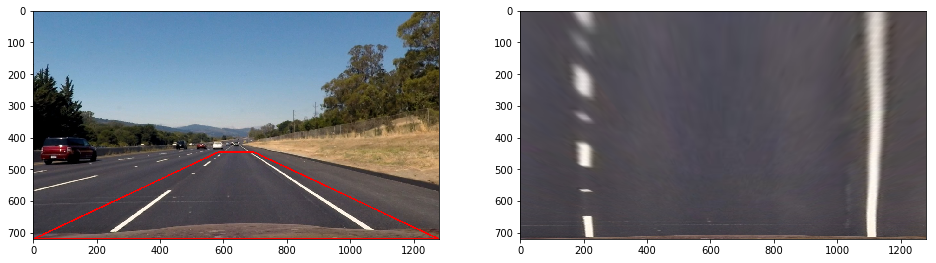

In [41]:
interact(show_warp,
         image_nr = [0, len(undistorted_test_images) - 1],
        x_deviation=widgets.FloatSlider(min=0.0,max=20.0,step=0.01,value=4.4),
        y_deviation=widgets.FloatSlider(min=0.0,max=20.0,step=0.1,value=12.0))

So good values for the perspective transformation are a x deviation of 4.4% and a y deviation of 12%. 

In [119]:
verts = get_region_of_interest_vertices(undistorted_test_images[0], 4.4, 12.0)
verts

array([[[   0,  720],
        [ 584,  446],
        [ 696,  446],
        [1280,  720]]], dtype=int32)

# Filter and warp Combination

In [43]:
def show_filter_and_warp(image_nr):
    verts = get_region_of_interest_vertices(undistorted_test_images[image_nr])
    warped = perspective_transform(undistorted_test_images[image_nr], verts)
    
    filtered = absolute_x_and_s(undistorted_test_images[image_nr])
    filtered_warped = perspective_transform(filtered, verts)

    plt.subplot(2,2,1)
    plt.imshow(draw_region_of_interest(undistorted_test_images[image_nr], verts))

    plt.subplot(2,2,2)
    plt.imshow(warped)
    
    plt.subplot(2,2,3)
    plt.imshow(filtered, cmap="gray")
    
    plt.subplot(2,2,4)
    plt.imshow(filtered_warped, cmap="gray")

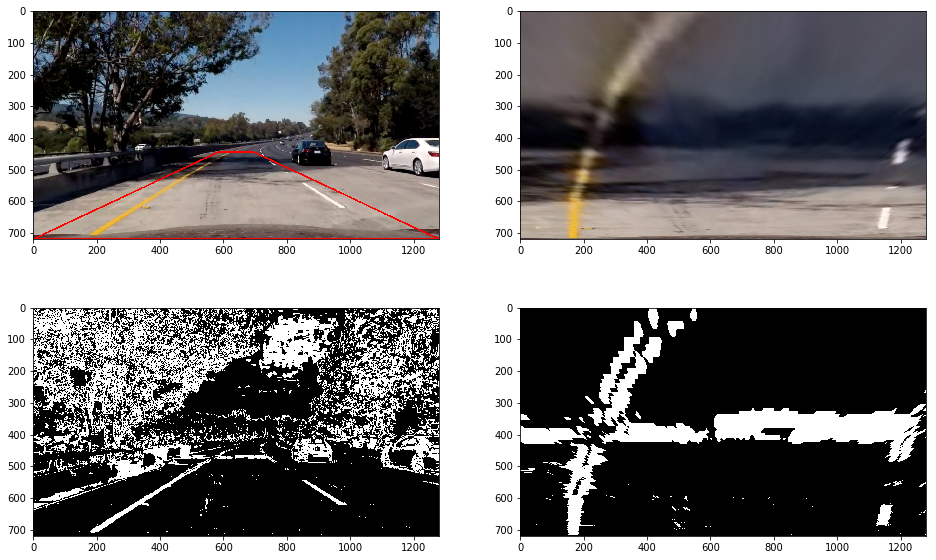

In [44]:
interact(show_filter_and_warp, image_nr = [0, len(undistorted_test_images) - 1])

# Lane Finding

To find the lanes the images are filtered and warped first.

In [45]:
verts = get_region_of_interest_vertices(undistorted_test_images[0], 4.4, 12.0)

warped_test_images = []
filtered_warped_test_images = []


for image in undistorted_test_images:
    warped = perspective_transform(image, verts)
    filtered = absolute_x_and_s(image)
    filtered_warped = perspective_transform(filtered, verts)
    
    warped_test_images.append(warped)
    filtered_warped_test_images.append(filtered_warped)
    

Here I will define some functions to create a horizontal sliding window for an image.

In [46]:
def get_horizontal_window_coords(image, window_height_precent, slide_percent):
    
    window_height_precent = np.clip(window_height_precent, 1, 100)
    slide_percent = np.clip(slide_percent, 0, 100)
    
    width = image.shape[1]
    height = image.shape[0]
    
    percent = slide_percent
    
    window_height = int((window_height_precent * height) / 100)
    
    bottom = int(((height - window_height) /100) * percent)
    top = int(bottom + window_height)
    
    return (0, bottom, width, top)

def cut_horizontal_window(image, window_height_precent, slide_percent):
    left, bottom, right , top = get_horizontal_window_coords(image, window_height_precent, slide_percent)
    
    return image[bottom:top:]

def draw_horizontal_window(image, window_height_precent, slide_percent):
    work_on_image = image.copy()
    
    left, bottom, right , top = get_horizontal_window_coords(image, window_height_precent, slide_percent)
    
    if len(image.shape) == 2:
        work_on_image = cv2.cvtColor(work_on_image * 255,cv2.COLOR_GRAY2RGB)

    cv2.rectangle(work_on_image, (left, bottom), ( right , top), color = (255,0,0), thickness = 3)
    return work_on_image
    

Lets interactively show the sliding window.

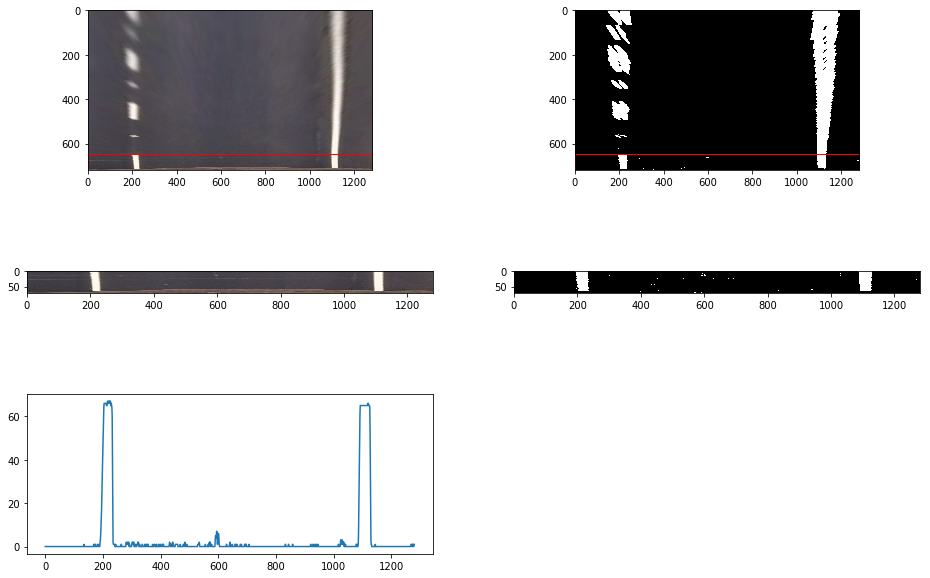

In [47]:
def show_sliding_window(percent, height, image_nr):
    ncols = 2
    nrows = 3
    
    plt.subplot(nrows, ncols, 1)
    plt.imshow(draw_horizontal_window(warped_test_images[image_nr], height, percent))
    plt.subplot(nrows, ncols, 2)
    plt.imshow(draw_horizontal_window(filtered_warped_test_images[image_nr], height, percent), cmap = "gray")
    plt.subplot(nrows, ncols, 3)
    plt.imshow(cut_horizontal_window(warped_test_images[image_nr], height, percent))
    plt.subplot(nrows, ncols, 4)
    plt.imshow(cut_horizontal_window(filtered_warped_test_images[image_nr], height, percent), cmap = "gray")
    plt.subplot(nrows, ncols, 5)
    plt.plot(np.sum(cut_horizontal_window(filtered_warped_test_images[image_nr], height, percent), axis = 0))


interact(show_sliding_window,
        height = widgets.IntSlider(min = 1, max = 100, step = 1, value = 10),
        percent = widgets.IntSlider(min = 0, max = 100, step = 10),
        image_nr = [0, len(undistorted_test_images) - 1]);

The idea is, to use the histogram of the sliding window to find regions in the image to look for lane lines. Therefore in the first step the window in the bottom of the image is used. Then the window will be split in half to look for left and right lane markers. At the bottom of the image, the lane lines should always be in the left and right of the image, as this is the part of the image closest to the car.

Then the peaks in the histogram are identified for each the left and the right part. With these peaks a search box is created, to look for the lane lines in the next sliding window. If there are multiple maximum values, the median of the indices where a maximum occures is used.

In [48]:
def get_new_search_box(new_box_center, box_width, minimum, maximum):
    new_box_left_index = np.clip(new_box_center - (box_width // 2), minimum, maximum)
    new_box_right_index = np.clip(new_box_center + (box_width // 2), minimum, maximum)
    return (new_box_left_index, new_box_right_index)

In [49]:
def draw_search_box(image, search_boxes, color):
    image = image.copy()
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
    
    for box in search_boxes:
        cv2.rectangle(image, box[0], box[1], color = color, thickness = 2)
    return image

def draw_search_boxes(image, search_boxes_left, search_boxes_right , color):
    left_boxes_image = draw_search_box(image, search_boxes_left, color)
    return draw_search_box(left_boxes_image, search_boxes_right, color)

In [50]:
def get_median_argmax(histogram):
    indeces_of_maxima = np.argwhere(histogram == np.max(histogram))
    return int(np.median(indeces_of_maxima))

In [51]:
def get_search_boxes(image, window_height_percent, search_box_width_pixels):
    
    image_height = image.shape[0]
    image_width = image.shape[1]

    image_center = image_width // 2

    search_box_left = (0, image_center)
    search_box_right = (image_center, image_width)

    result_box_left = []
    result_box_right = []

    for window_percent in range(100,-1, -window_height_percent):
        window = cut_horizontal_window(image, window_height_percent, window_percent)
        histogram = np.sum(window, axis = 0)
        left_max_index = get_median_argmax(histogram[search_box_left[0]:search_box_left[1]]) + search_box_left[0]
        right_max_index = get_median_argmax(histogram[search_box_right[0]:search_box_right[1]]) + search_box_right[0]

        search_box_left = get_new_search_box(left_max_index, search_box_width_pixels, 0, image_width)
        search_box_right = get_new_search_box(right_max_index, search_box_width_pixels, 0, image_width)

        result_box_left.append(((search_box_left[0], window_percent * image_height // 100),(search_box_left[1], window_percent * image_height // 100  + window_height_percent * image_height // 100)))
        result_box_right.append(((search_box_right[0], window_percent * image_height // 100),(search_box_right[1], window_percent * image_height // 100  + window_height_percent * image_height // 100)))

    return result_box_left, result_box_right


Lets take a look at the search boxes for different images and parameters.

In [52]:
def show_search_boxes(image_nr, box_heigt_percent, box_width_pixels):
    image = filtered_warped_test_images[image_nr] * 255
    result_box_left, result_box_right = get_search_boxes(image, box_heigt_percent, box_width_pixels)
    plt.imshow(draw_search_boxes(image, result_box_left, result_box_right, (66, 244, 78)), cmap = "gray")

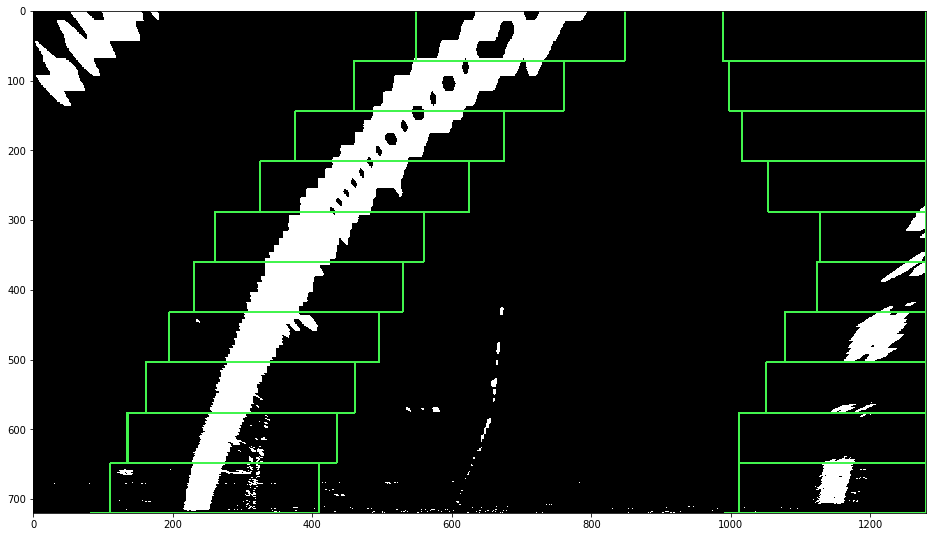

In [53]:
interact(show_search_boxes,
        box_heigt_percent = widgets.IntSlider(5, 0, 100, 1),
        box_width_pixels = widgets.IntSlider(300, 0, 1280, 1),
        image_nr = [0, len(filtered_warped_test_images) - 1])

In [54]:
def mask_image_with_boxes(image, boxes):
    mask = np.zeros_like(image)
    for box in boxes:
        mask[box[0][1]:box[1][1], box[0][0]:box[1][0]] = 1
    
    return mask * image

In [88]:
def fit_lane(image, result_boxes):
    lane_pixels = mask_image_with_boxes(image, result_boxes)
    x_y_positions = np.argwhere(lane_pixels > 0)
    
    fit = np.polyfit(x_y_positions[:,0], x_y_positions[:,1], 2)
    
    # Get curvature
    y_eval = image.shape[0]
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 70/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    fit_cr = np.polyfit(x_y_positions[:,0]*ym_per_pix, x_y_positions[:,1]*xm_per_pix, 2)
    # Calculate the new radii of curvature
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])
    
    return fit, curverad
    

In [56]:
def color_lane_pixels(image, left_result_boxes, right_result_boxes):
    image = image.copy()
        
    left_lane_pixels = mask_image_with_boxes(image, left_result_boxes)
    right_lane_pixels = mask_image_with_boxes(image, right_result_boxes)
    
    if len(image.shape) == 2:
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)

    image[left_lane_pixels > 0] = [255, 173, 43]
    image[right_lane_pixels > 0] = [42, 205, 255]
    
    return image

In [57]:
def plot_fitted_lines(image, left_fit, right_fit):
    # Generate x and y values for plotting
    ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, image.shape[1])
    plt.ylim(image.shape[0], 0)

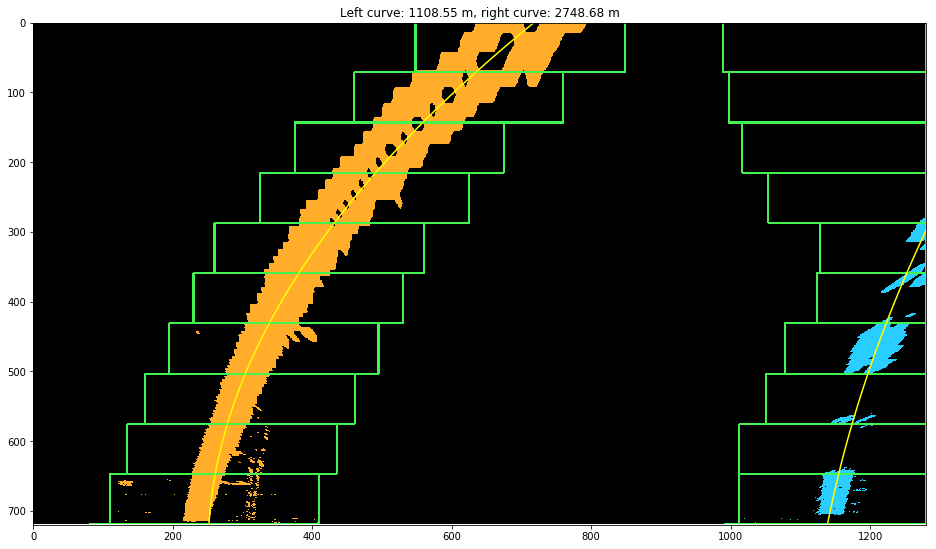

In [58]:
def show_lane_finding(image_nr):
    image = filtered_warped_test_images[image_nr]
    result_boxes_left, result_boxes_right = get_search_boxes(image, 10, 300)

    left_fit, left_curve = fit_lane(image, result_boxes_left)
    right_fit, right_curve = fit_lane(image, result_boxes_right)

    result_image = color_lane_pixels(image, result_boxes_left, result_boxes_right)
    result_image = draw_search_boxes(result_image, result_boxes_left, result_boxes_right, color=(66, 244, 78))

    plt.imshow(result_image)
    plot_fitted_lines(result_image, left_fit, right_fit)
    plt.title("Left curve: {:.2f} m, right curve: {:.2f} m".format(left_curve, right_curve))
    
interact(show_lane_finding,
        image_nr = [0, len(filtered_warped_test_images) - 1])


In [59]:
def draw_lines(binary_image, original_image, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    src_verts = np.float32(get_region_of_interest_vertices(original_image))
    dst_verts = np.float32(get_image_corner_vertices(original_image))
    
    
    Minv = cv2.getPerspectiveTransform(dst_verts, src_verts)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    return cv2.addWeighted(original_image, 1, newwarp, 0.3, 0)


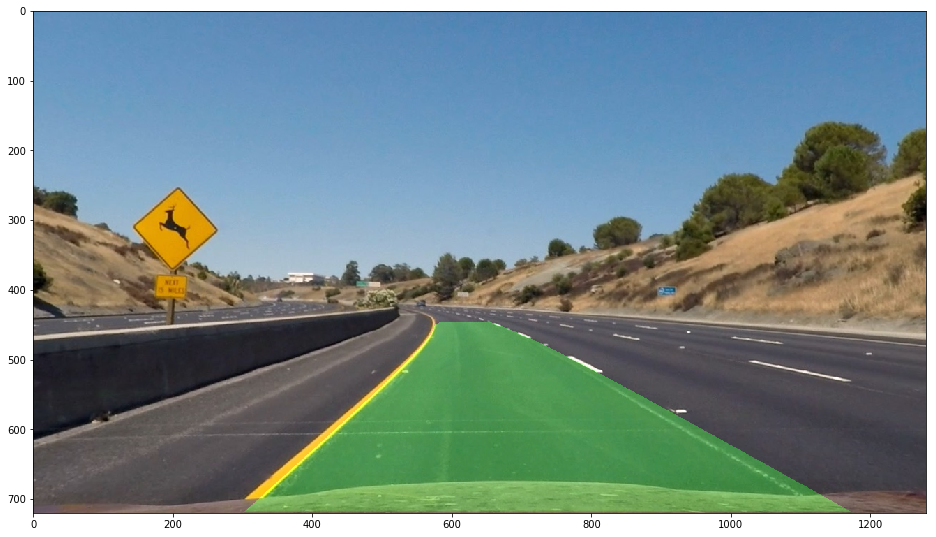

In [60]:
def show_lane_lines_on_original_image(image_nr):
    original_image = undistorted_test_images[image_nr]
    binary_image = filtered_warped_test_images[image_nr]
    result_boxes_left, result_boxes_right = get_search_boxes(binary_image, 10, 300)

    left_fit, left_curve = fit_lane(binary_image, result_boxes_left)
    right_fit, right_curve = fit_lane(binary_image, result_boxes_right)

    result = draw_lines(binary_image, original_image, left_fit, right_fit)
    plt.imshow(result)
    
interact(show_lane_lines_on_original_image,
        image_nr = [0, len(filtered_warped_test_images) - 1])


Find lane lines, using previous lines.

# Lane detection in Videos

With videos we can use some smoothing along the frames of the video, to get a more stable output. In the following class the new fit coefficients get saved and older ones discarded. The median for these coefficients can be queried to get a smoothed out line. 

In [62]:
class Smooth_Vector:
    
    def __init__(self):
        self.window_size = 15
        self.vectors = []
        
    def add_vector(self, vector):
        self.vectors.append(vector)
        
        while len(self.vectors) > self.window_size:
            self.vectors.pop(0)
        
    def get_smooth_vector(self):
        return np.median(np.array(self.vectors), axis=0)
    
    def reset(self):
        self.vectors = []
        
    def set_window_size(self, window_size):
        self.window_size = window_size
        
left_fit_smooth = Smooth_Vector()
right_fit_smooth = Smooth_Vector()
curve_smooth = Smooth_Vector()

Below is the image processing pipeline. 

In [109]:
def _get_x(y, fit):
    return fit[0]*y**2 + fit[1]*y + fit[2]

def get_deviation_from_center(image, left_fit, right_fit):
    
    image_height = image.shape[0]
    image_middle = image.shape[1] // 2
    
    x_left_bottom = _get_x(image_height, left_fit)
    x_right_bottom = _get_x(image_height, right_fit)
    
    lanes_middle = (x_left_bottom + x_right_bottom) // 2
    
    return (lanes_middle - image_middle) * 2.7 / 900

In [110]:

def image_processing_pipeline(image):
    # Undistort image
    undist = undistort(image, calibration_values)
    
    # Create binary image
    filtered = absolute_x_and_s(undist)

    # Transform perspective
    verts = get_region_of_interest_vertices(undist)
    filtered_warped = perspective_transform(filtered, verts)
    
    # Find lane line
    result_boxes_left, result_boxes_right = get_search_boxes(filtered_warped, 10, 300)

    left_fit, left_curve = fit_lane(filtered_warped, result_boxes_left)
    right_fit, right_curve = fit_lane(filtered_warped, result_boxes_right)
    
    left_fit_smooth.add_vector(left_fit)
    right_fit_smooth.add_vector(right_fit)
    
    curve_smooth.add_vector(left_curve)
    curve_smooth.add_vector(right_curve)
    
    # Project lane lines back to orignial image
    result = draw_lines(filtered_warped, undist, left_fit_smooth.get_smooth_vector(), right_fit_smooth.get_smooth_vector())
    
    # Create Debugging Images
    image_height = result.shape[0]
    image_width = result.shape[1]
    
    search_output = color_lane_pixels(filtered_warped, result_boxes_left, result_boxes_right)
    search_output = draw_search_boxes(search_output, result_boxes_left, result_boxes_right, color=(66, 244, 78))
    search_output = cv2.resize(search_output, (image_width // 3, image_height // 3))

    filtered_warped_small = cv2.resize(filtered_warped, (image_width // 3, image_height // 3))
    filtered_warped_small = cv2.cvtColor(filtered_warped_small * 255, cv2.COLOR_GRAY2RGB)

    output = np.zeros((image_height + image_height // 3, image_width, 3))

    output[:image_height,:image_width] = result
    output[image_height:,:filtered_warped_small.shape[1]] = filtered_warped_small
    output[image_height:,filtered_warped_small.shape[1]:filtered_warped_small.shape[1] + search_output.shape[1]] = search_output

    cv2.putText(output, "Curvature: {:08.2f} m".format(curve_smooth.get_smooth_vector()), 
                (filtered_warped_small.shape[1] + search_output.shape[1] + 10, image_height + 50),
               fontFace = cv2.FONT_HERSHEY_DUPLEX, fontScale = 1.1, color = (255, 255, 255))
    
    
    center_dev = get_deviation_from_center(filtered_warped, left_fit_smooth.get_smooth_vector(), 
                                           right_fit_smooth.get_smooth_vector())
    
    cv2.putText(output, "Center dev: {:06.4f} m".format(center_dev), 
                (filtered_warped_small.shape[1] + search_output.shape[1] + 10, image_height + 100),
               fontFace = cv2.FONT_HERSHEY_DUPLEX, fontScale = 1.1, color = (255, 255, 255))
    
    
    return np.uint8(output)
    

In [111]:
!mkdir video_out

mkdir: video_out: File exists


Here we can test the pipeline on single images.

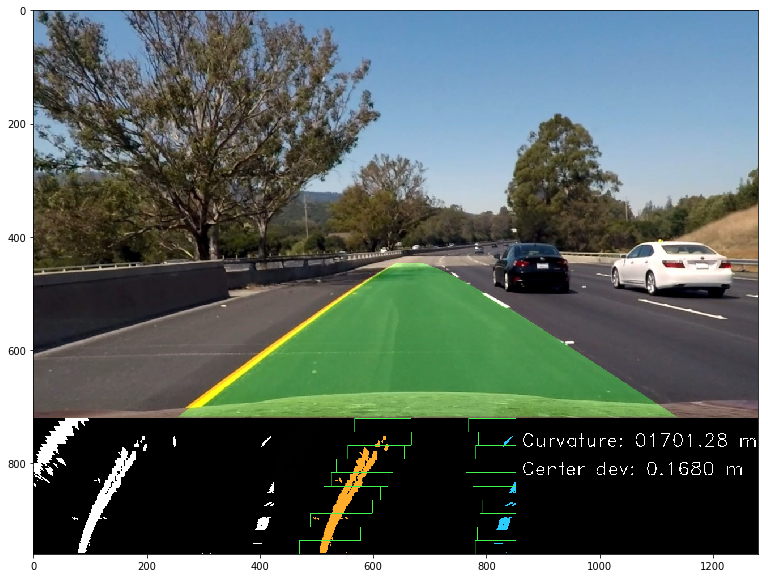

In [112]:
def show_image_processing(image_nr):
    left_fit_smooth.reset()
    right_fit_smooth.reset()
    curve_smooth.reset()

    result = image_processing_pipeline(test_images[image_nr])
    plt.imshow(result)
    
interact(show_image_processing,
         image_nr = [0, len(test_images) - 1])

## Project Video

### Without smoothing

In [105]:
left_fit_smooth.reset()
right_fit_smooth.reset()
curve_smooth.reset()
left_fit_smooth.set_window_size(1)
right_fit_smooth.set_window_size(1)
curve_smooth.set_window_size(1)

output = 'video_out/project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(image_processing_pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_out/project_video.mp4
[MoviePy] Writing video video_out/project_video.mp4


100%|█████████▉| 1260/1261 [02:57<00:00,  7.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/project_video.mp4 

CPU times: user 3min 21s, sys: 56.5 s, total: 4min 18s
Wall time: 2min 58s


In [106]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

### With smoothing

In [113]:
left_fit_smooth.reset()
right_fit_smooth.reset()
curve_smooth.reset()
left_fit_smooth.set_window_size(20)
right_fit_smooth.set_window_size(20)
curve_smooth.set_window_size(20)

output_smooth = 'video_out/project_video_smooth.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(image_processing_pipeline)
%time white_clip.write_videofile(output_smooth, audio=False)

[MoviePy] >>>> Building video video_out/project_video_smooth.mp4
[MoviePy] Writing video video_out/project_video_smooth.mp4


100%|█████████▉| 1260/1261 [02:53<00:00,  7.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/project_video_smooth.mp4 

CPU times: user 3min 18s, sys: 54.8 s, total: 4min 13s
Wall time: 2min 54s


In [114]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_smooth))

## Challenge Video

In [115]:
left_fit_smooth.reset()
right_fit_smooth.reset()

output = 'video_out/challenge_video.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(image_processing_pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_out/challenge_video.mp4
[MoviePy] Writing video video_out/challenge_video.mp4


100%|██████████| 485/485 [01:05<00:00,  7.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/challenge_video.mp4 

CPU times: user 1min 15s, sys: 21.7 s, total: 1min 37s
Wall time: 1min 6s


In [116]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

## Hard Challenge Video

In [117]:
left_fit_smooth.reset()
right_fit_smooth.reset()

output = 'video_out/harder_challenge_video.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
white_clip = clip1.fl_image(image_processing_pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video_out/harder_challenge_video.mp4
[MoviePy] Writing video video_out/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [02:55<00:00,  6.99it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video_out/harder_challenge_video.mp4 

CPU times: user 3min 20s, sys: 52.6 s, total: 4min 12s
Wall time: 2min 56s


In [118]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))